In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.distributions as dist
from torch.utils.data import DataLoader

torch.manual_seed(0)

import matplotlib.pyplot as plt
import numpy as np

from time import time



In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
EPS = 1e-6
DIAG = 0.1

# One dimensional - KL - 1 to 2

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=1, num_component_output=2):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.inp_dim = int(self.num_component_input*(1+self.xdim+self.xdim*(self.xdim+1)/2))    # changed to take as input the parameters of the tgauss
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.inp_dim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )


    def forward(self, params):

        output = self.network(params)

        weights = torch.sigmoid(output[:, :self.num_component_output])
        weights = weights / weights.sum(dim=1).unsqueeze(-1)
        mus = torch.exp(output[:, self.num_component_output : self.num_component_output + self.num_component_output*self.xdim])                                                      
        covs = torch.exp(output[:, self.num_component_output + self.num_component_output*self.xdim:]) + EPS

        return weights, mus, covs

### Dataset generation

In [4]:
def generate_random_covariance(dim, lb, ub):
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub)                # strictly positive diagonal
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())                                # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    return cov_matrix


def generate_tgauss_dataset(niter, mean_bounds, sigma_bounds, ncomp, xdim):
    """ generates a list of parameters for truncated Gaussians """
    trunc_gauss = []
    for _ in range(niter):
        weights = torch.rand(ncomp)
        weights = weights / weights.sum()  # Normalize to sum to 1
        means = torch.empty(ncomp, xdim).uniform_(mean_bounds[0], mean_bounds[1])
        covariances = torch.empty(ncomp, xdim, xdim)
        for j in range(ncomp):
            covariances[j] = generate_random_covariance(xdim, sigma_bounds[0], sigma_bounds[1])
        trunc_gauss.append(torch.hstack([weights, means.flatten(), covariances.flatten()]))
    return torch.stack(trunc_gauss)

def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = samples < 0
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

def trunc_gauss_sampling(mu, sigma, num_samples):
    sampling_dist = dist.Normal(mu, torch.sqrt(sigma))
    samples = sampling_dist.sample((num_samples,))
    samples = _truncate_samples(samples, sampling_dist)
    return samples

In [5]:
# half of the samples are close to zero

niter = 100_000 # number of gaussian mixtures seen during training

ncomp = 1
xdim = 1

lb1_mu = 0
ub1_mu = 1
lb1_sigma = -1
ub1_sigma = 1

lb2_mu = 0
ub2_mu = 20
lb2_sigma = -5
ub2_sigma = 5


In [6]:
trunc_gauss1 = generate_tgauss_dataset(int(0.5*niter), [lb1_mu, ub1_mu], [lb1_sigma, ub1_sigma], ncomp, xdim)
trunc_gauss2 = generate_tgauss_dataset(int(0.5*niter), [lb2_mu, ub2_mu], [lb2_sigma, ub2_sigma], ncomp, xdim)

trunc_gauss = torch.vstack([trunc_gauss1, trunc_gauss2])
trunc_gauss = trunc_gauss[torch.randperm(len(trunc_gauss))]

##### Generation of mixtures with EM

In [7]:
from sklearn.mixture import GaussianMixture

output_mix = []

nsamples = 500

for params in trunc_gauss:
    samples = trunc_gauss_sampling(params[1], params[2], nsamples)
    gm = GaussianMixture(n_components=2, covariance_type='full').fit(samples.reshape(-1,1))
    gm_params = gm.weights_
    for i in range(2):
        gm_params = np.hstack((gm_params, gm.means_[i]))
    for i in range(2):
        gm_params = np.hstack((gm_params,gm.covariances_[i][0]))
    output_mix.append(gm_params)

trunc gauss tensor([1.0000e+00, 4.8743e-01, 3.6565e-04])
gm params [5.20307754e-01 4.79692246e-01 4.76657571e-01 5.01915128e-01
 2.19740246e-04 2.44760430e-04]


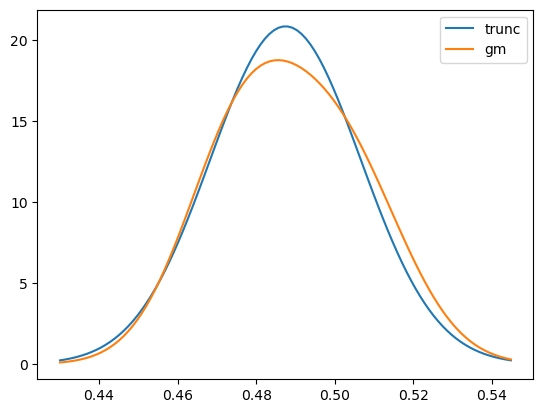

In [15]:
from scipy.stats import truncnorm
from scipy.stats import norm

idx = 5

print('trunc gauss', trunc_gauss[idx])
print('gm params', output_mix[idx])

params = trunc_gauss[idx]
weights = output_mix[idx][:2]
means = output_mix[idx][2:4]
covs = output_mix[idx][4:]

loc = params[1]
scale = torch.sqrt(params[2])
a = -loc/scale
b = np.inf

x = np.linspace(loc-3*scale, loc+3*scale, 100)

y_trunc = truncnorm.pdf(x, a, b, loc, scale)
plt.plot(x, y_trunc, label='trunc')


y_gm = sum([weights[i]*norm.pdf(x, means[i], np.sqrt(covs[i])) for i in range(2)])
plt.plot(x, y_gm.reshape(x.shape), label='gm')

plt.legend()

In [16]:
training_dataset = torch.hstack((trunc_gauss, torch.tensor(output_mix, dtype=torch.float32)))

In [34]:
#torch.save(training_dataset, './params/training_dataset.pt')
training_dataset = torch.load('./params/training_dataset.pt')

In [35]:
training_dataset = DataLoader(training_dataset, batch_size = 64, shuffle=True)

#### Loss function

In [83]:
EPS = 10**(-6)

def mean_square_loss(true_gm, pred_gm):

    loss_weights = torch.pow(torch.abs(true_gm[:2] - pred_gm[:2]), 2).sum()

    true_means = true_gm[2:4]
    pred_means = pred_gm[2:4]
    loss_means = (torch.pow(torch.abs(true_means-pred_means), 2)/((true_means + pred_means)/2)).sum()

    true_covs = true_gm[4:]
    pred_covs = pred_gm[4:]
    loss_covs = torch.pow(torch.abs(true_covs - pred_covs), 2).sum()

    return loss_weights + loss_means + loss_covs
    

def loss_function_minibatch(tbatch, new_pi, new_mu, new_sigma):
    total_loss = torch.tensor(0.)
    output_params = torch.hstack((new_pi, new_mu, new_sigma))
    for idx, inp in enumerate(tbatch):
        loss = mean_square_loss(inp[3:], output_params[idx])
        total_loss += loss
    return total_loss/tbatch.shape[0]

def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):

    model.train()
    counter = 0
    losses = []

    for batch_idx, tbatch in enumerate(training_dataset):

        pi_new, mu_new, sigma_new = model(tbatch[:,:3])
        
        loss = loss_fn(tbatch, pi_new, mu_new, sigma_new)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print information
        if counter % 1000 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}")
            losses.append(loss)

        if counter % 1000 == 0:
            print('trunc:', tbatch[0,:3])
            print('EM:', tbatch[0,3:])
            print('pred:', pi_new[0], mu_new[0], sigma_new[0])

        counter += 1

    return losses

#### Training 10 epochs

In [ ]:
ncomp_inp = 1
ncomp_out = 2
xdim = 1

epochs = 10

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp_inp, num_component_output=ncomp_out)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

for t in range(epochs):
    print(f"\nEpoch {t+1}\n-------------------------------")
    losses = train_loop_minibatch(training_dataset, model, loss_function_minibatch, optimizer)

print("Done!")
torch.save(model, 'params/truncNNdim1-EM-10ep-1to2.pth')


Epoch 1
-------------------------------
loss: 61.610016
trunc: tensor([1.0000, 0.3918, 0.0787])
EM: tensor([0.6127, 0.3873, 0.2929, 0.6282, 0.0229, 0.0406])
pred: tensor([0.4755, 0.5245], grad_fn=<SelectBackward0>) tensor([0.9398, 0.8958], grad_fn=<SelectBackward0>) tensor([1.0475, 0.8898], grad_fn=<SelectBackward0>)
loss: 58.069843
trunc: tensor([ 1.0000, 11.8451,  6.1169])
EM: tensor([ 0.4157,  0.5843, 10.0562, 13.1868,  3.6788,  3.3049])
pred: tensor([0.5006, 0.4994], grad_fn=<SelectBackward0>) tensor([7.3920, 2.9729], grad_fn=<SelectBackward0>) tensor([0.5109, 0.6081], grad_fn=<SelectBackward0>)

Epoch 2
-------------------------------
loss: 31.158043
trunc: tensor([1.0000, 0.0682, 0.5685])
EM: tensor([0.4735, 0.5265, 0.2820, 0.9366, 0.0328, 0.1711])
pred: tensor([0.4891, 0.5109], grad_fn=<SelectBackward0>) tensor([1.1050, 1.1330], grad_fn=<SelectBackward0>) tensor([0.9701, 0.9089], grad_fn=<SelectBackward0>)
loss: 28.781891
trunc: tensor([ 1.0000, 13.0692,  0.2251])
EM: tensor([ 

### Testing

In [48]:
test_means = []
test_covs = []

pred_weights = []
pred_means = []
pred_covs = []

times = []

for i in range(10):
    
    test_means.append(torch.empty(ncomp, xdim).uniform_(0, 2))
    test_covs.append(torch.empty(ncomp, xdim, xdim))

    for j in range(ncomp):
      test_covs[-1] = generate_random_covariance(xdim, -5, 5)

    params = torch.hstack([torch.tensor([1.]), test_means[-1].flatten(), test_covs[-1].flatten()]).reshape(1,3)

    start = time()
    pi_pred, mu_pred, sigma_pred = model(params)
    end = time()
    times.append(end-start)

    pred_weights.append(pi_pred)
    pred_means.append(mu_pred)
    pred_covs.append(sigma_pred)



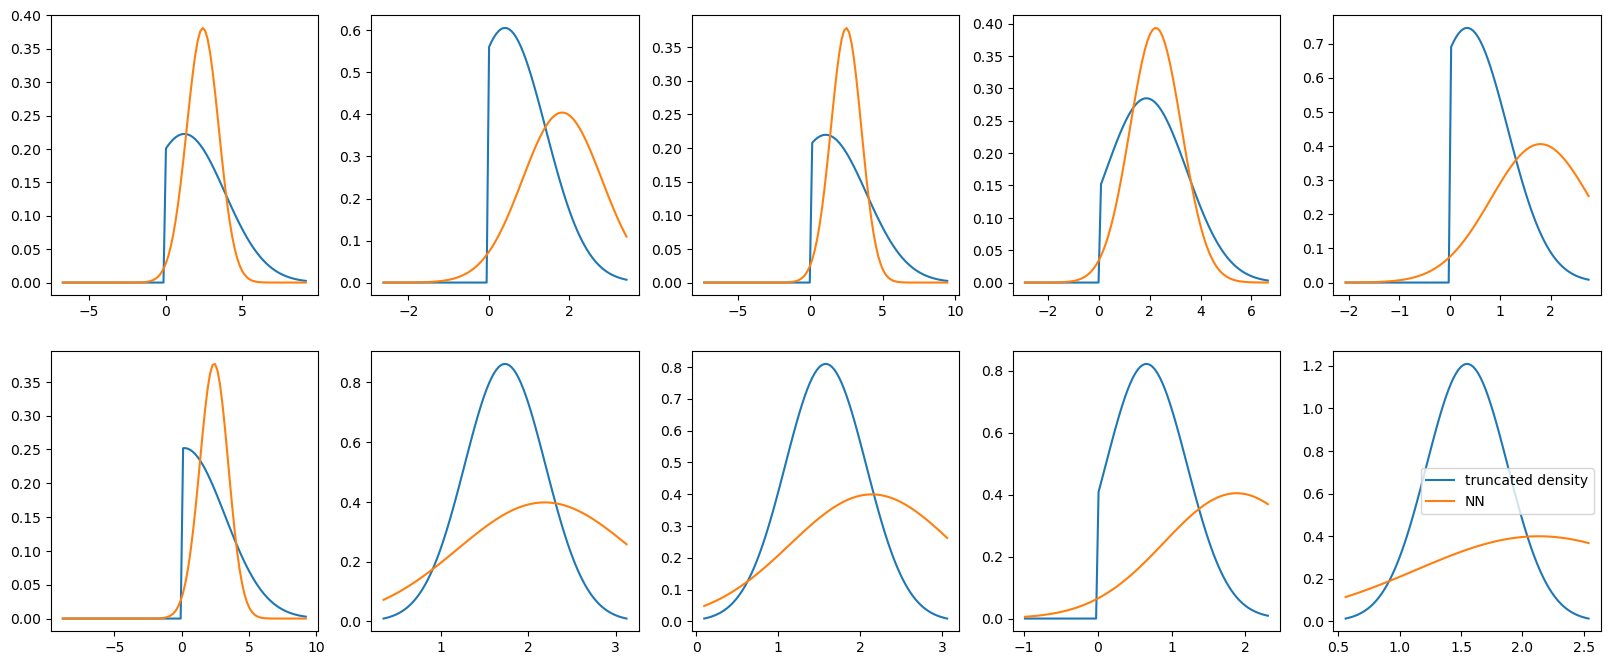

In [51]:
from scipy.stats import truncnorm
from scipy.stats import norm

def plot_gm(x, pis, mus, sigmas, ncomp=2):
    return sum([pis[i]*norm.pdf(x, loc=mus[i], scale=np.sqrt(sigmas[i])) for i in range(ncomp)])

# Plotting
x = np.linspace(-5,8,100)

#plt.hist(test_samples.t(), bins=10, range=(40,50), density=True, label='samples')

plt.figure(figsize=(20,8))

for i in range(10):

    loc = test_means[i]
    scale = np.sqrt(test_covs[i])
    a = -loc/scale
    b = np.inf

    x = np.linspace(loc-3*scale,loc+3*scale,100).reshape((100,))

    y_trunc = truncnorm.pdf(x, a, b, loc, scale).reshape(x.shape)

    weights = pred_weights[i].flatten().detach().numpy()
    means = pred_means[i].flatten().detach().numpy()
    vars = pred_covs[i].flatten().detach().numpy()

    y_nn = plot_gm(x, weights, means, vars)
    
    plt.subplot(2, 5, i+1)
    plt.plot(x, y_trunc, label='truncated density')
    plt.plot(x, y_nn, label='NN')

plt.legend()

plt.savefig('EM.pdf')

#### Debug

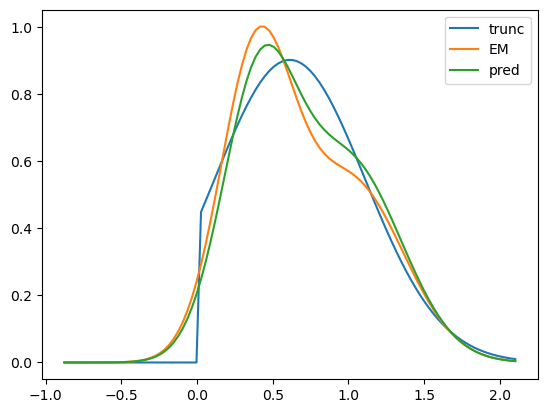

In [63]:
from scipy.stats import truncnorm
from scipy.stats import norm


trunc_params  = torch.tensor([1.0000, 0.6129, 0.2462])
em_params = torch.tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred_params = torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.12, 0.06]) #torch.tensor([0.5127, 0.4873, 2.0055, 1.7072, 0.9804, 0.9270])


params = trunc_gauss[idx]

em_weights = em_params[:2]
em_means = em_params[2:4]
em_covs = em_params[4:]

pred_weights = pred_params[:2]
pred_means = pred_params[2:4]
pred_covs = pred_params[4:]

loc = trunc_params[1]
scale = torch.sqrt(trunc_params[2])
a = -loc/scale
b = np.inf

x = np.linspace(loc-3*scale, loc+3*scale, 100)

y_trunc = truncnorm.pdf(x, a, b, loc, scale)
plt.plot(x, y_trunc, label='trunc')

y_em = sum([em_weights[i]*norm.pdf(x, em_means[i], np.sqrt(em_covs[i])) for i in range(2)])
plt.plot(x, y_em.reshape(x.shape), label='EM')

y_gm = sum([pred_weights[i]*norm.pdf(x, pred_means[i], np.sqrt(pred_covs[i])) for i in range(2)])
plt.plot(x, y_gm.reshape(x.shape), label='pred')

plt.legend()

In [54]:
mean_square_loss(em_params, pred_params)

tensor(3.7333)

In [58]:
print('em params', em_params)
print('pred params', pred_params)

mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.9804, 0.9270]))

em params tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred params tensor([0.5127, 0.4873, 2.0055, 1.7072, 0.9804, 0.9270])


tensor(1.0153)

In [61]:
print('em params', em_params)
print('pred params', pred_params)

mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 2.0055, 1.7072, 0.12, 0.06]))

em params tensor([0.4680, 0.5320, 1.0158, 0.3885, 0.1212, 0.0575])
pred params tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.9804, 0.9270])


tensor(2.7984)

In [62]:
mean_square_loss(em_params, torch.tensor([0.5127, 0.4873, 1.0055, 0.4072, 0.12, 0.06]))

tensor(0.0804)